# E2a: Küchentischversuch zum Laval-Rotor

Name:Paul Zuendel 
Datum:09.01.2024  

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Wie stark sind die Schwingungen von Alltagsgegenständen, die Vibrationen ausführen und ist der Pi geeignet, solche Schwingungen in hoher Frequenz zu messen?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

![Veruschsaufbau](Versuchsaufbau_Handy.jpg)

- Beschreibung des Aufbaus: Beschleunigungssensor wird auf ein Handy gelegt
- Vorgangsbeschreibung: Der Sensor misst für ca. 20 Sekunden die Beschleunigung in X-, Y- und Z-Richtung, während das Smartphone einen Wecker ausführt und entsprechend in einem gewissen Rhythmus vibriert.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [41]:
import h5py
import numpy as np
import json
import os
from typing import Tuple

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)
import numpy as np
from numpy.fft import fft, ifft
from typing import Tuple


def get_vec_accel(x: np.ndarray, y: np.ndarray, z: np.ndarray) -> np.ndarray:
   
    x_beschl_q2 = np.square(x)
    y_beschl_q2 = np.square(y)
    z_beschl_q2 = np.square(z)

    abs_beschl = np.sqrt(x_beschl_q2 + y_beschl_q2 + z_beschl_q2)

    return abs_beschl

def interpolation(time: np.ndarray, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
    interpolation_time = np.linspace(np.min(time), np.max(time), len(time))
    interpolated_data = np.interp(interpolation_time, time, data)
    return interpolated_data

def my_fft(x: np.ndarray, time: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
    mittelwert = np.mean(x)
    daten_null_mittelwert = x-mittelwert


    x = daten_null_mittelwert    # altes x überschreiben
    sr = len(time)/(np.max(time)-np.min(time))

    X = fft(x)
    N = len(X)
    n = np.arange(N)
    T = N/sr
    freq = n/T 

# Get the one-sided specturm
    n_oneside = N//2
# get the one side frequency
    f_oneside = freq[:n_oneside]

# normalize the amplitude
    X_oneside =X[:n_oneside]/n_oneside
    
    return X_oneside, f_oneside

#### 1a. Einlesen der Mess- und Metadaten

In [42]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = 'measurement_data' # replace None by the relative path to the first object's folder
h5_file_name = 'data_20240109_135508_PaulZuendel_handy.h5' # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [43]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240109_140308_PaulZuendel_mixer/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_140308_PaulZuendel_mixer/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240109_140308_PaulZuendel_mixer/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeaee9e-4e7d-6228-9b4a-2faa55d7d9ea": {
    "type": "probe",
    "name": "mixer",
    "comment": "",
    "path": "measurement_data/data_2024

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [44]:
path = 'measurement_data/data_20240109_135508_PaulZuendel_handy/data_20240109_135508_PaulZuendel_handy.h5'

# Lese die Daten aus der HDF5-Datei
file = h5py.File(path, 'r')

data = file['1ee847be-fddd-6ee4-892a-68c4555b0981']
        
time = np.array(data['timestamp'])
beschleunigung_x = np.array(data['acceleration_x'])
beschleunigung_y = np.array(data['acceleration_y'])
beschleunigung_z = np.array(data['acceleration_z'])

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [45]:
betrag_beschl = get_vec_accel(beschleunigung_x, beschleunigung_y, beschleunigung_z)

print(betrag_beschl)

[9.01512272 8.97680836 8.97680836 ... 9.04808956 9.00291063 9.00291063]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0, 0.5, 'delta t')

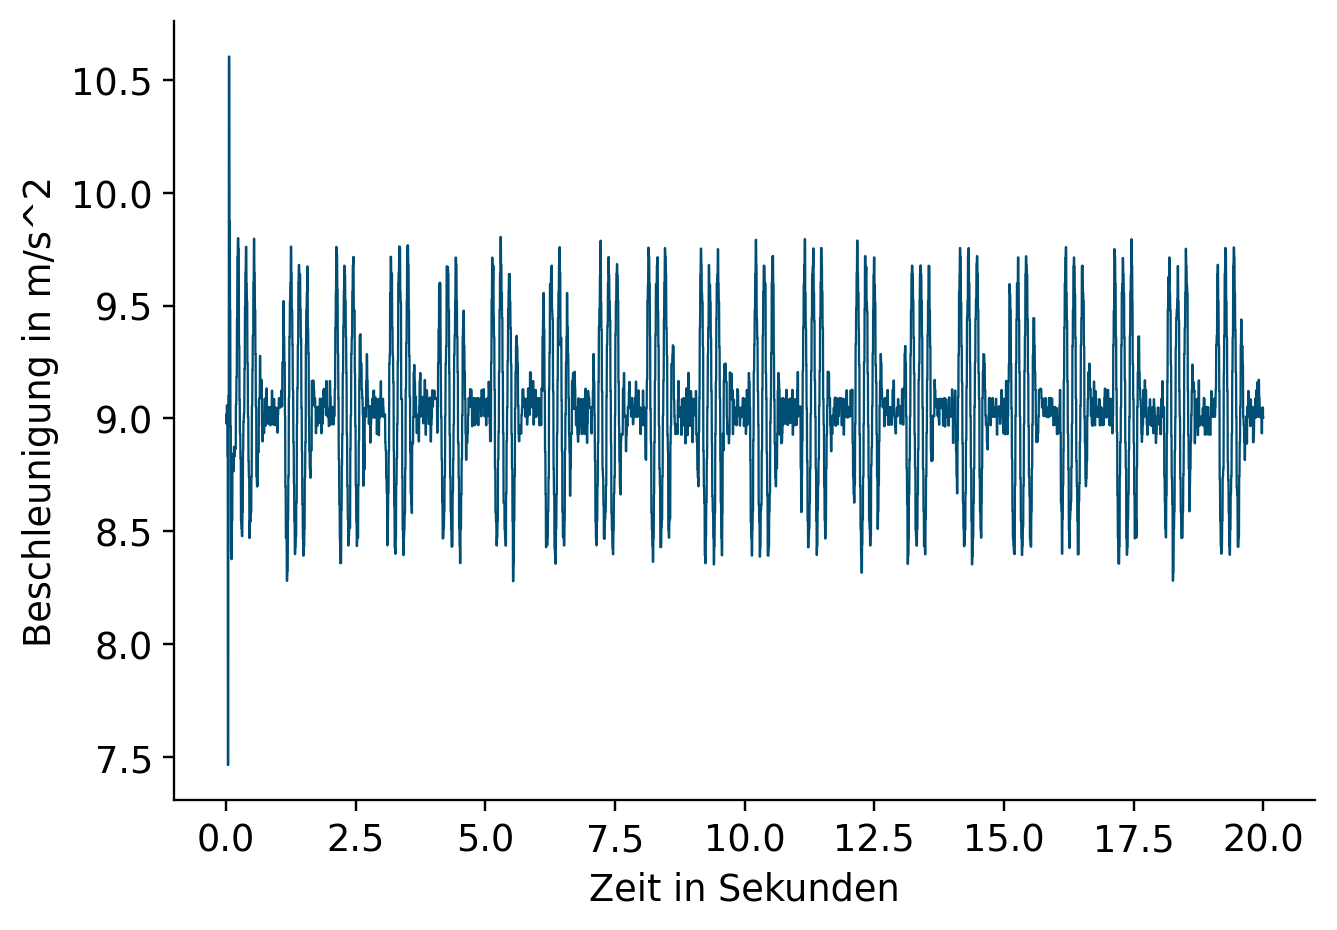

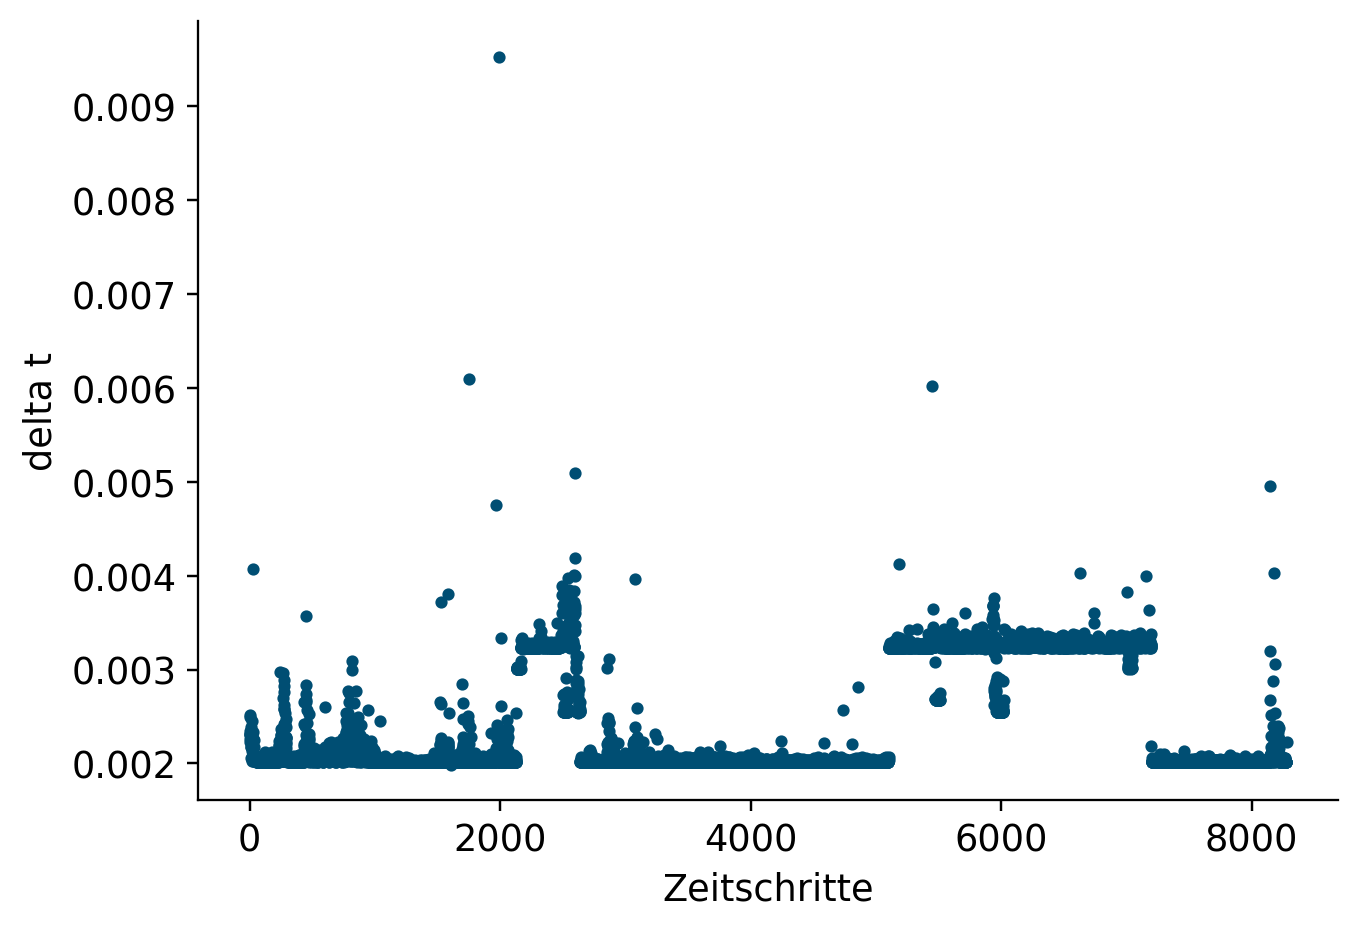

In [46]:
fig = plt.figure()
plt.plot(time, betrag_beschl)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')
#print(range(len(time)))

delta_t_liste = []
for i in range(1, (len(time))):
    delta_t_liste.append(time[i] - time[i-1])
    
fig2 = plt.figure()
plt.plot(delta_t_liste, '.')
plt.xlabel('Zeitschritte')
plt.ylabel('delta t')

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [47]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.

interpolierte_daten = interpolation(time, betrag_beschl)
print(interpolierte_daten)
print(time)

[9.01512272 8.97839225 8.97680836 ... 9.04808956 9.00719339 9.00291063]
[1.11651421e-03 3.63588333e-03 5.86605072e-03 ... 1.99949040e+01
 1.99969165e+01 1.99991410e+01]


#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude')

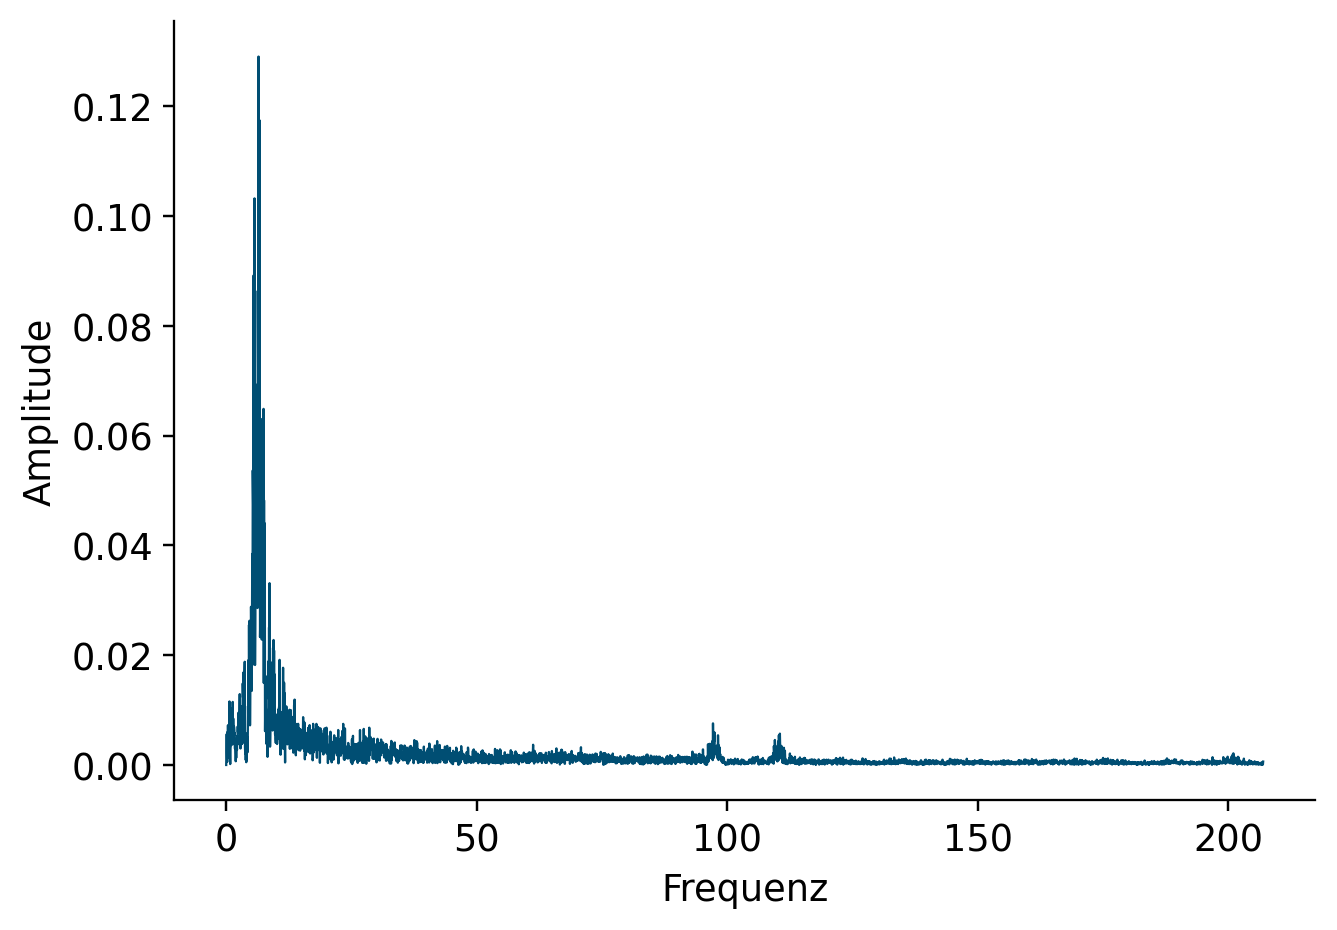

In [48]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.

X_oneside, f_oneside = my_fft(interpolierte_daten, time)

fig2 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz')
plt.ylabel('Amplitude')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

![Veruschsaufbau](Versuchsaufbau_Mixer.jpg)

Beschreibung des Aufbaus: Beschleunigungssensor wird auf den Mixer gelegt
Vorgangsbeschreibung: Der Sensor misst für ca. 20 Sekunden die Beschleunigung in X-, Y- und Z-Richtung, während der Mixer auf mittlerer Stufe läuft.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [49]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = 'measurement_data' # replace None by the relative path to the first object's folder
h5_file_name = 'data_20240109_140308_PaulZuendel_mixer.h5' # replace None by the filename of the hdf5-file

"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))

{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240109_140308_PaulZuendel_mixer/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_140308_PaulZuendel_mixer/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240109_140308_PaulZuendel_mixer/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeaee9e-4e7d-6228-9b4a-2faa55d7d9ea": {
    "type": "probe",
    "name": "mixer",
    "comment": "",
    "path": "measurement_data/data_2024

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [50]:
path = 'measurement_data/data_20240109_140308_PaulZuendel_mixer/data_20240109_140308_PaulZuendel_mixer.h5'

# Lese die Daten aus der HDF5-Datei
file = h5py.File(path, 'r')

data = file['1ee847be-fddd-6ee4-892a-68c4555b0981']
        
time = np.array(data['timestamp'])
beschleunigung_x = np.array(data['acceleration_x'])
beschleunigung_y = np.array(data['acceleration_y'])
beschleunigung_z = np.array(data['acceleration_z'])

#### 2. Betrag der Beschleunigung berechnen


In [51]:
betrag_beschl = get_vec_accel(beschleunigung_x, beschleunigung_y, beschleunigung_z)

print(betrag_beschl)

[ 9.73515387  9.73515387  9.73515387 ... 10.06343878 10.06343878
 10.06343878]


#### 3. Darstellung der Messdaten

Text(0, 0.5, 'delta t')

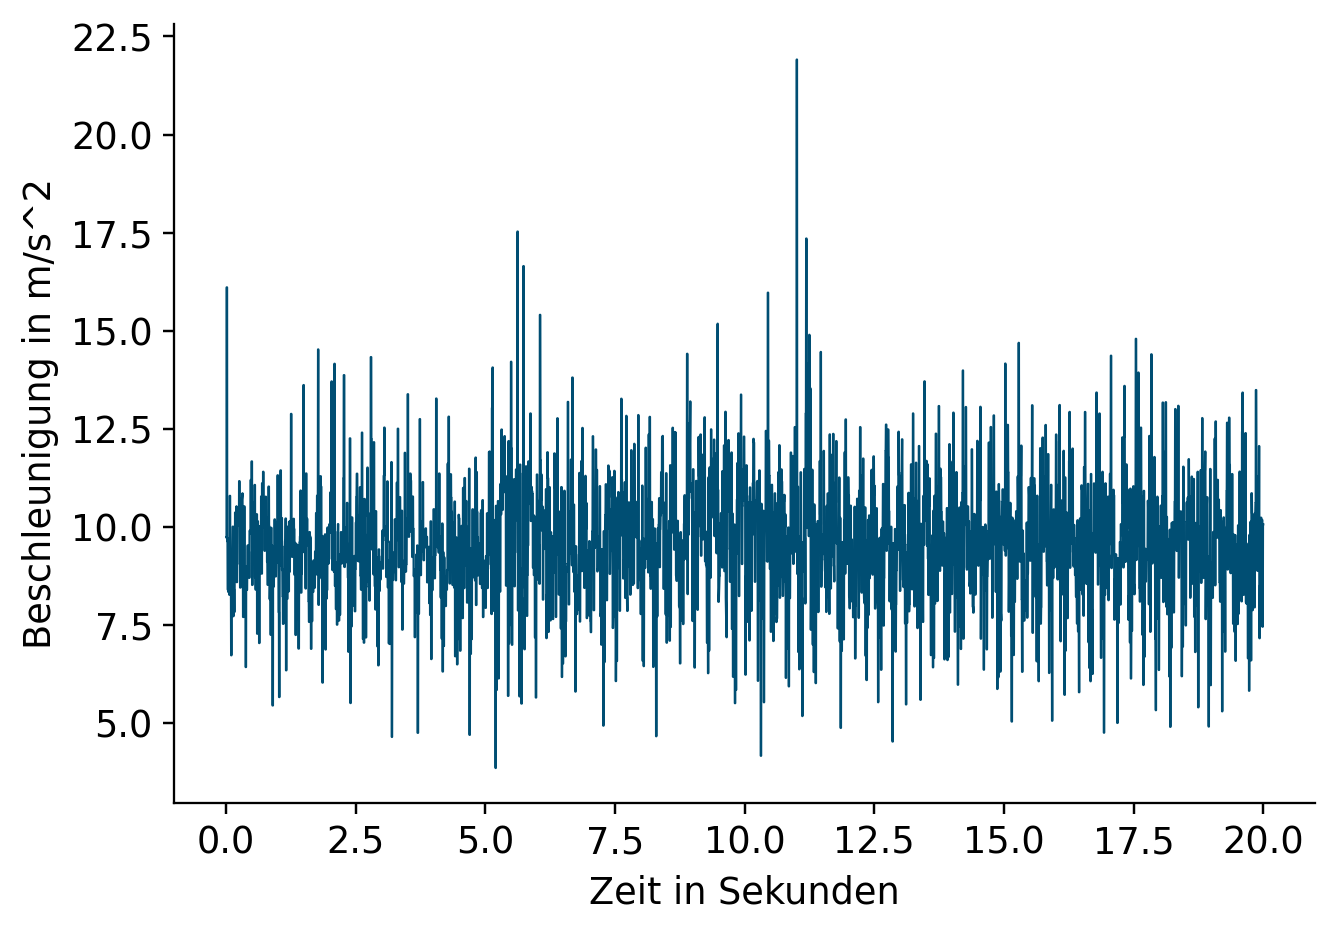

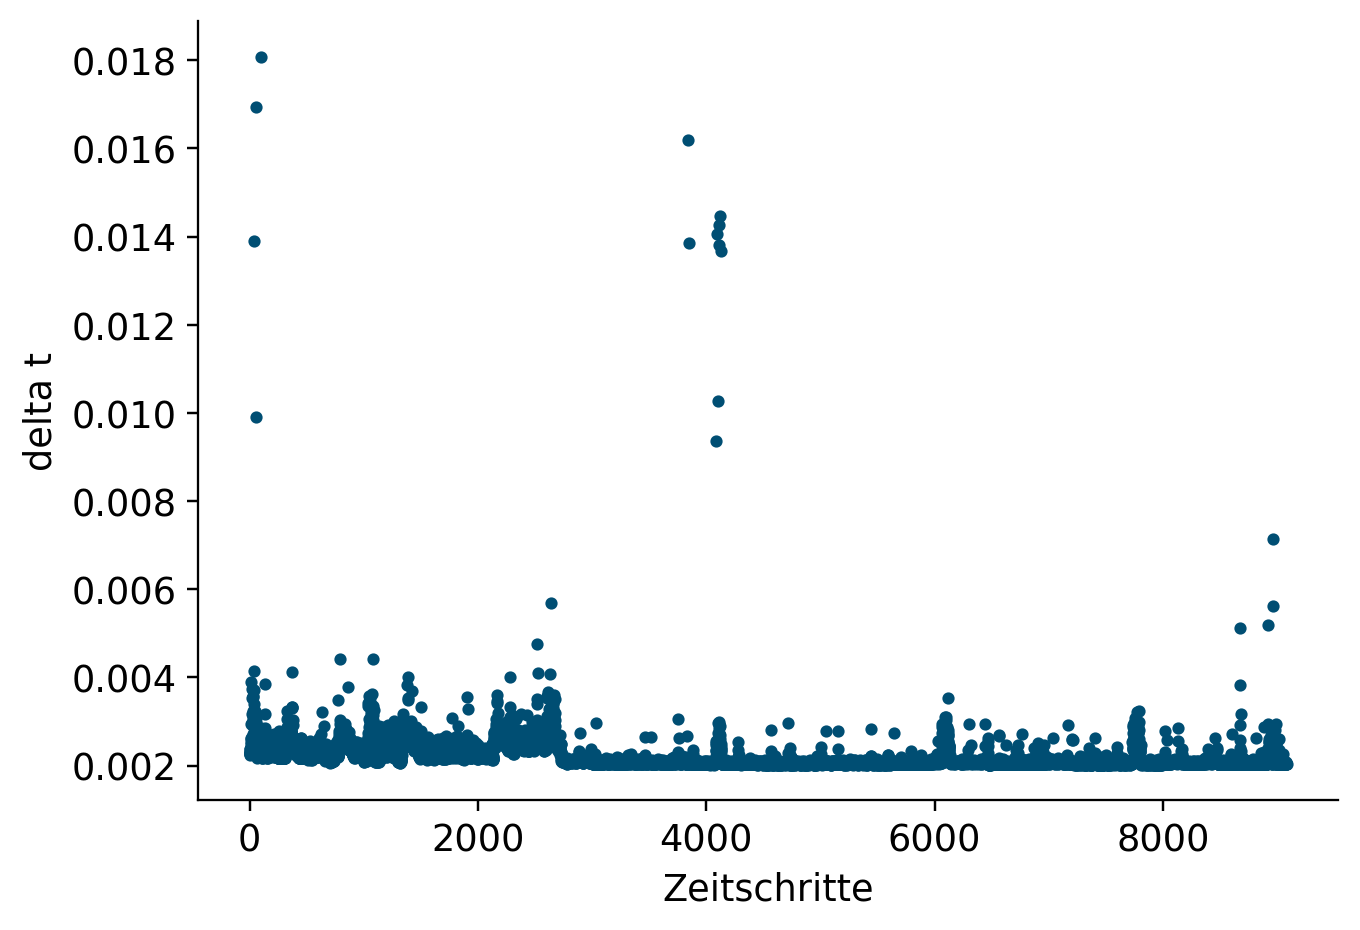

In [52]:
fig = plt.figure()
plt.plot(time, betrag_beschl)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')
#print(range(len(time)))

delta_t_liste = []
for i in range(1, (len(time))):
    delta_t_liste.append(time[i] - time[i-1])
    
fig2 = plt.figure()
plt.plot(delta_t_liste, '.')
plt.xlabel('Zeitschritte')
plt.ylabel('delta t')

#### 4. Interpolation der Messwerte



In [53]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.

interpolierte_daten = interpolation(time, betrag_beschl)
print(interpolierte_daten)
print(time)

[ 9.73515387  9.73515387  9.73515387 ... 10.06343878 10.06343878
 10.06343878]
[1.17230415e-03 3.47757339e-03 5.73873520e-03 ... 1.99951737e+01
 1.99972060e+01 1.99992373e+01]


#### 5 & 6. FFT durchführen und graphisch darstellen


Text(0, 0.5, 'Amplitude')

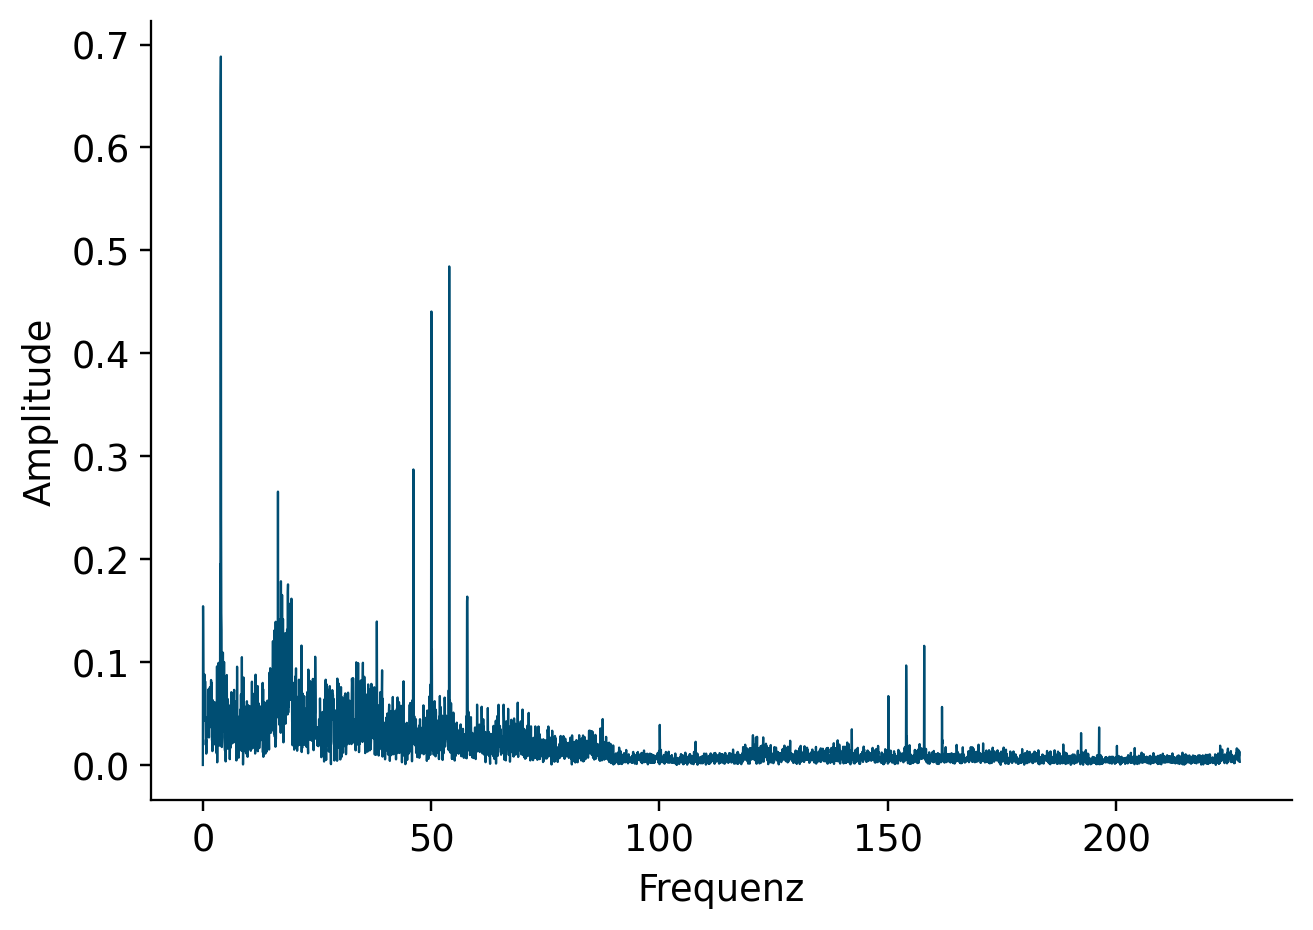

In [54]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.

X_oneside, f_oneside = my_fft(interpolierte_daten, time)

fig2 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz')
plt.ylabel('Amplitude')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

 Wie man am Vergleich der Graphen der Beschleunigungen über der Zeit von Handy und Mixer erkennen kann, verursacht der Mixer deutlich größere Beschleunigungen als das Handy. Mit 10 bzw 20 m/s^2 als maximale Beschleunigungen der Gegenstände sind Werte zur persönlichen Einordung der Stärke der Vibration der beiden Gegenstände gemessen worden. Was vor allem bei der Handymessung auffällt ist, dass die gemessende Beschleunigung einem gleichmäßigen Muster folgt, was auch der Vibrationseinstellung entspricht. Der Sensor konnte den Verlauf bis auf den Ausreißer bei Messbeginn somit sehr gut erfassen. Gleiches gilt auch für den Mixer bei dem der Senosr klare tiefs und spitzen erfassen konnte. Fraglich ist aber ob eine so gute Darstellung auch bei höherfrequenten Gegenständen erfolgen kann oder ob der Sensor dann überfordert wäre. Die Fouriertransformationen bestätigen zudem den gleichmäßigen Schwingungscharakter des Handys und zeigen, dass der Mixer deutlich ungleichmäßiger mit einigen Ausreißern ist.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Der Versuch war meiner Meinung nach deutlich interessanter als die vorherigen und auch vom Umfang angemessener und nachvollziehbarer. Es war vor allem sehr interessant einmal Werte für die verursachten Schwingungen von Alltagsgegenständen zu sehen und diese Einorden zu können.